In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from pandas import DataFrame
from scipy import stats
from sklearn import preprocessing
from scipy.stats import zscore

import seaborn as sns
import matplotlib.pylab as plt

%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import seaborn as sns
import matplotlib.pylab as plt
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

In [ ]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

**Merge History Transaction Data**

In [ ]:
train = reduce_mem_usage(pd.read_csv("../input/train.csv"))
test = reduce_mem_usage(pd.read_csv("../input/test.csv"))
hist_txns = reduce_mem_usage(pd.read_csv("../input/historical_transactions.csv"))
new_txns = reduce_mem_usage(pd.read_csv("../input/new_merchant_transactions.csv"))
merchants = reduce_mem_usage(pd.read_csv("../input/merchants.csv"))
all_txns = pd.concat([hist_txns, new_txns], ignore_index=True)

**Filter only valid transactions**

In [ ]:
all_txns_train=all_txns[(all_txns['card_id'].isin(train['card_id']))].reset_index()
all_txns_test=all_txns[(all_txns['card_id'].isin(test['card_id']))].reset_index()
del all_txns
del hist_txns
del new_txns

In [ ]:
all_txns_train.head(5)
all_txns_train.isnull().sum()

**Fix Null**

In [ ]:
le = preprocessing.LabelEncoder()
for dataset in [all_txns_train,all_txns_test]:
    dataset['category_1_en']=le.fit_transform(dataset['category_1'])
    g = pd.Series(dataset['category_3'], dtype="category")
    dataset['category_3']=g.cat.add_categories("D").fillna("D")
    dataset['category_3_en']=le.fit_transform(dataset['category_3'])
    dataset['category_2']=dataset['category_2'].fillna(0)
    dataset.drop(['index','category_1','category_3','merchant_category_id'],axis=1,inplace=True)
    #dataset[dataset.columns[dataset.dtypes != np.object]] = dataset[dataset.columns[dataset.dtypes != np.object]].abs()
        

In [ ]:
all_txns_train.head(5)
all_txns_train.isnull().sum()
all_txns_train.dtypes


**Univariate Analysis**

In [ ]:
col_names=['city_id','installments','month_lag','purchase_amount','category_2','state_id','subsector_id','category_1_en','category_3_en']
#fig, ax = plt.subplots(len(col_names), figsize=(16,12)),
fig, ax = plt.subplots(9, 2, figsize = (15, 35))
for i, col_val in enumerate(col_names):
    sns.boxplot(x= all_txns_train[col_val], ax = ax[i,0])
    sns.distplot(all_txns_train[col_val], ax = ax[i,1])
plt.tight_layout()

In [ ]:
col_names=['city_id','installments','month_lag','purchase_amount','category_2','state_id','subsector_id','category_1_en','category_3_en']
#fig, ax = plt.subplots(len(col_names), figsize=(16,12)),
fig, ax = plt.subplots(9, 2, figsize = (15, 35))
for i, col_val in enumerate(col_names):
    sns.boxplot(x= all_txns_test[col_val], ax = ax[i,0])
    sns.distplot(all_txns_test[col_val], ax = ax[i,1])
plt.tight_layout()

In [ ]:
col_names=['city_id','installments','month_lag','category_2','state_id','subsector_id','category_1_en','category_3_en']
for i, col_val in enumerate(col_names):
    print ("Unique Values for {}  {}" .format(col_val,sorted(all_txns_train[col_val].unique())))

**Groupby cardId and apply aggregateion based on Univariate analysis**

In [ ]:
train_data = all_txns_train.groupby("card_id").agg({
            "city_id": {'mode': lambda x: x.mode()[0],'unique':lambda x: x.nunique()},
            "installments": {'mode': lambda x: x.mode()[0],'sum':np.sum,'unique':lambda x: x.nunique()},
            "month_lag":{'mode': lambda x: x.mode()[0],'sum':np.sum,'unique':lambda x: x.nunique()},
            "purchase_amount": [np.mean,np.sum],
            "purchase_date": [np.max],
            "merchant_id":{'unique':lambda x: x.nunique()},
            "category_2": {"0": lambda x: x[x==0].count(),
                           "1": lambda x: x[x==1].count(),
                           "2": lambda x: x[x==2].count(),
                           "3": lambda x: x[x==3].count(),
                           "4": lambda x: x[x==4].count(),
                           "5": lambda x: x[x==5].count()},
            "authorized_flag": {"Y": lambda x: x[x == 'Y'].count(),
                                "N": lambda x: x[x == 'N'].count()},
            "state_id": {'mode': lambda x: x.mode()[0],'unique':lambda x: x.nunique()},
            "subsector_id": {'mode': lambda x: x.mode()[0],'unique':lambda x: x.nunique()},
            "category_1_en": {"0": lambda x: x[x==0].count(),
                              "1": lambda x: x[x==1].count()},
            "category_3_en": {"0": lambda x: x[x==0].count(),
                              "1": lambda x: x[x==1].count(),
                              "2": lambda x: x[x==2].count(),
                              "3": lambda x: x[x==3].count()}
        })
train_data.columns = ["_".join(x) for x in train_data.columns.ravel()]
train_data = train_data.reset_index()
    
test_data = all_txns_test.groupby("card_id").agg({
            "city_id": {'mode': lambda x: x.mode()[0],'unique':lambda x: x.nunique()},
            "installments": {'mode': lambda x: x.mode()[0],'sum':np.sum,'unique':lambda x: x.nunique()},
            "month_lag":{'mode': lambda x: x.mode()[0],'sum':np.sum,'unique':lambda x: x.nunique()},
            "purchase_amount": [np.mean,np.sum],
            "purchase_date": [np.max],
            "merchant_id":{'unique':lambda x: x.nunique()},
            "category_2": {"0": lambda x: x[x==0].count(),
                           "1": lambda x: x[x==1].count(),
                           "2": lambda x: x[x==2].count(),
                           "3": lambda x: x[x==3].count(),
                           "4": lambda x: x[x==4].count(),
                           "5": lambda x: x[x==5].count()},
            "authorized_flag": {"Y": lambda x: x[x == 'Y'].count(),
                                "N": lambda x: x[x == 'N'].count()},
            "state_id": {'mode': lambda x: x.mode()[0],'unique':lambda x: x.nunique()},
            "subsector_id": {'mode': lambda x: x.mode()[0],'unique':lambda x: x.nunique()},
            "category_1_en": {"0": lambda x: x[x==0].count(),
                              "1": lambda x: x[x==1].count()},
            "category_3_en": {"0": lambda x: x[x==0].count(),
                              "1": lambda x: x[x==1].count(),
                              "2": lambda x: x[x==2].count(),
                              "3": lambda x: x[x==3].count()}
        })
test_data.columns = ["_".join(x) for x in test_data.columns.ravel()]
test_data = test_data.reset_index()
    
#Append the grouped data to train/test set based on cardID
train_data = train.join(train_data.set_index("card_id"), on="card_id")
test_data = test.join(test_data.set_index("card_id"), on="card_id")

In [9]:
train_data['target']=train_data['target'].astype('float64')

Bivariate against target

In [ ]:
def scatter_p(fea,target):
    n_f = len(fea)
    n_row = n_f//3+1
    fig=plt.figure(figsize=(20,15))
    i = 1
    for f in fea:
        x=train_data[f]
        y=train_data[target]
        m, b = np.polyfit(x, y, 1)    
        
        ax=fig.add_subplot(n_row,3,i)
        plt.plot(x,y,'.',color='b')
        plt.plot(x, m*x + b, '-',color='r')
        plt.xlabel(f)
        plt.ylabel(target)
        i += 1

In [ ]:
scatter_p(fea=['feature_1','feature_2', 'feature_3','city_id_mode','city_id_unique','installments_mode'],target='target')

In [ ]:
scatter_p(fea=['installments_sum','installments_unique', 'month_lag_mode','month_lag_sum','month_lag_unique','purchase_amount_mean'],target='target')

In [ ]:
scatter_p(fea=['purchase_amount_sum','merchant_id_unique', 'state_id_mode','state_id_unique','subsector_id_mode','subsector_id_unique'],target='target')

In [ ]:
plt.figure(figsize=(8,8))
plt.hist(train_data.target,bins=10,color='b')
plt.title('Histogram of target')
plt.show()

In [10]:
train_data_dummies=train_data.drop(['first_active_month','card_id','target','purchase_date_amax'],1)
test_data_dummies=test_data.drop(['first_active_month','card_id','purchase_date_amax'],1)
y_train=train_data.loc[:,train_data.columns=='target']

In [11]:
train_data_dummies = pd.get_dummies(train_data_dummies, columns=['feature_1','feature_2','feature_3'])
test_data_dummies = pd.get_dummies(test_data_dummies, columns=['feature_1','feature_2','feature_3'])

In [16]:
train_data_dummies.head()

,city_id_mode,city_id_unique,installments_mode,installments_sum,installments_unique,month_lag_mode,month_lag_sum,month_lag_unique,purchase_amount_mean,purchase_amount_sum,merchant_id_unique,category_2_0,category_2_1,category_2_2,category_2_3,category_2_4,category_2_5,authorized_flag_Y,authorized_flag_N,state_id_mode,state_id_unique,subsector_id_mode,subsector_id_unique,category_1_en_0,category_1_en_1,category_3_en_0,category_3_en_1,category_3_en_2,category_3_en_3,feature_1_1,feature_1_2,feature_1_3,feature_1_4,feature_1_5,feature_2_1,feature_2_2,feature_2_3,feature_3_0,feature_3_1
0,-0.597562,0.939537,-0.738435,-0.554690,-0.563581,0.489216,-0.971623,0.458545,-0.003037,-0.014150,2.260470,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,1.794725,0.442647,-0.267853,0.045415,0.685138,1.612435,1.865411,-0.333868,2.382449,-0.466892,-0.557439,-0.427906,-0.251779,-0.617946,-0.757132,-0.330513,1.992552,-0.889961,1.303080,-0.480201,-0.876431,0.876431
1,-0.597562,0.939537,0.552686,4.659456,2.378682,1.060632,-2.234287,1.567382,-0.002993,-0.016763,3.166259,0.0,0.0,-0.0,-0.0,-0.0,-0.0,2.532686,0.274495,-0.267853,0.045415,0.685138,2.187267,2.268767,1.240727,-0.522021,3.312391,5.993349,0.762221,-0.251779,-0.617946,-0.757132,3.025597,-0.501869,1.123645,-0.767412,-0.480201,1.140992,-1.140992
2,0.093086,-0.113231,-0.738435,-0.592959,-0.983905,-1.796449,0.038180,1.012964,-0.003101,-0.003045,-0.749088,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.448675,-0.482193,-0.887491,-0.579466,0.570980,-0.878507,-0.429878,-0.333868,-0.063968,-0.521270,-0.557439,-0.427906,-0.251779,1.618264,-0.757132,-0.330513,-0.501869,-0.889961,1.303080,-0.480201,1.140992,-1.140992
3,-1.082882,0.413153,0.552686,0.258525,0.277065,-0.082200,0.304177,-0.373082,-0.003053,-0.004851,0.507329,0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.035417,-0.650346,1.745971,1.295177,1.027613,0.462769,-0.170578,0.326446,-0.522021,0.484726,0.079443,1.357285,-0.251779,-0.617946,-0.757132,3.025597,-0.501869,-0.889961,-0.767412,2.082459,1.140992,-1.140992
4,-1.082882,0.413153,0.552686,1.483132,0.697389,0.774924,0.453595,-0.927500,-0.002714,-0.005926,1.822184,0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.751741,-0.229964,1.745971,2.544939,1.027613,1.229213,0.607324,0.529620,-0.522021,1.653857,0.170426,0.167158,3.971737,-0.617946,-0.757132,-0.330513,-0.501869,-0.889961,-0.767412,2.082459,1.140992,-1.140992


In [15]:
from scipy.stats import zscore
train_data_dummies=train_data_dummies.apply(zscore)
test_data_dummies=test_data_dummies.apply(zscore)

/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:107: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True)


In [17]:
from keras import models
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.layers import BatchNormalization
from keras import backend
from keras.callbacks import EarlyStopping,ModelCheckpoint

Using TensorFlow backend.


In [18]:
def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true)))

In [19]:
#Initialize Sequential Graph (model)
model = models.Sequential()
#Add Dense layer for prediction - Keras declares weights and bias automatically 
model.add(Dense(150, input_dim=len(train_data_dummies.columns),kernel_initializer='normal', activation='relu'))
model.add(BatchNormalization())
#model.add(Dropout(0.2))
model.add(Dense(100, activation='relu'))
model.add(Dense(60, activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(30, activation='relu'))
model.add(Dense(1, activation='linear'))
#Create optimizer with non-default learning rate 
sgd_optimizer = optimizers.SGD(lr=0.0003, momentum=0.9, decay=0.0, nesterov=False) 
#Compile the model - add Loss and Gradient Descent optimizer 
#early_stop = EarlyStopping(monitor='rmse', patience=3)
model.compile(optimizer='adam', loss='mse', metrics=['mse',rmse])
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='rmse', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
history = model.fit(train_data_dummies, y_train, epochs=20,callbacks=callbacks_list)
print (model.summary)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/20
201917/201917 [==============================] - 30s 148us/step - loss: 14.6993 - mean_squared_error: 14.6993 - rmse: 3.1263

Epoch 00001: rmse improved from inf to 3.12635, saving model to weights.best.hdf5
Epoch 2/20
201917/201917 [==============================] - 25s 124us/step - loss: 14.6314 - mean_squared_error: 14.6314 - rmse: 3.1245

Epoch 00002: rmse improved from 3.12635 to 3.12453, saving model to weights.best.hdf5
Epoch 3/20
201917/201917 [==============================] - 26s 131us/step - loss: 14.6100 - mean_squared_error: 14.6100 - rmse: 3.1232

Epoch 00003: rmse improved from 3.12453 to 3.12319, saving model to weights.best.hdf5
Epoch 4/20
201917/201917 [==============================] - 25s 124us/step - loss: 14.5737 - mean_squared_error: 14.5737 - rmse: 3.1294

Epoch 00004: rmse did not improve from 3.12319
Epoch 5/20
201917/201917 [=====

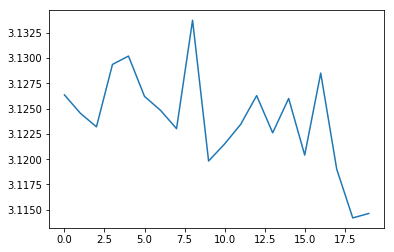

In [20]:
import matplotlib.pyplot as plt
plt.plot(history.history['rmse'])
plt.show()

In [ ]:
model.load_weights('weights.best.hdf5')
test_data['target'] = model.predict(test_data_dummies)
print (test_data[['card_id','target']].head(10))
submission_file = test_data[['card_id', 'target']]
# print (submission_file.head(20))

submission_file.to_csv('submission.csv', index=False)